In [23]:
# !pip install 'gym[box2d]'
# !apt-get install python-opengl -y
# !apt install xvfb -y
# !pip install pyvirtualdisplay
# !pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
# !apt-get install ffmpeg -y

In [24]:
# env.render() gives error in Colab
# below code solves display error
# https://github.com/openai/gym/issues/1898


from pyvirtualdisplay import Display
display = Display(visible=0,size=(600,600))
display.start()

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from maze_env import Maze
from utils import plot_policy, plot_values, test_agent,plot_action_values

np.random.seed(6585)

In [26]:
# initialze the env
env = Maze()

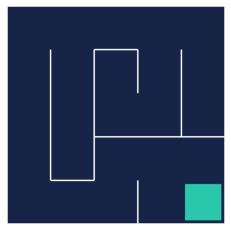

In [27]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [28]:
# intialize action value table Q(s,a)
action_values = np.full((5,5,4),-100)

# set action value at the goal to 4
action_values[4,4:] =0.

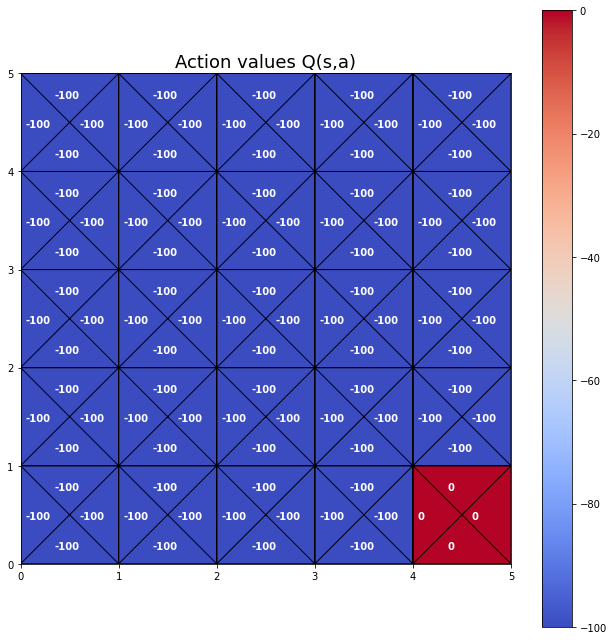

In [29]:
# plot action value
plot_action_values(action_values)

In [30]:
# define target policy

def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

In [31]:
action = target_policy((0,0))
action

1

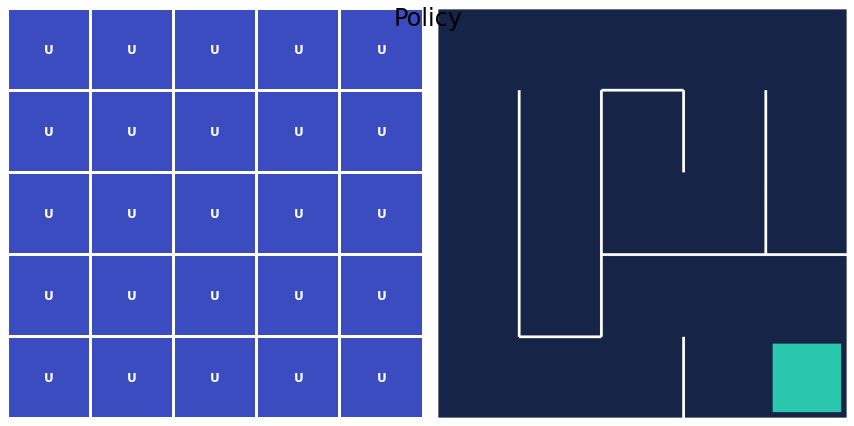

In [32]:
plot_policy(action_values,frame)

In [33]:
# exploratory policy
def exploratory_policy(state,epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [34]:
action = exploratory_policy((0,0),epsilon=0.5)
action

1

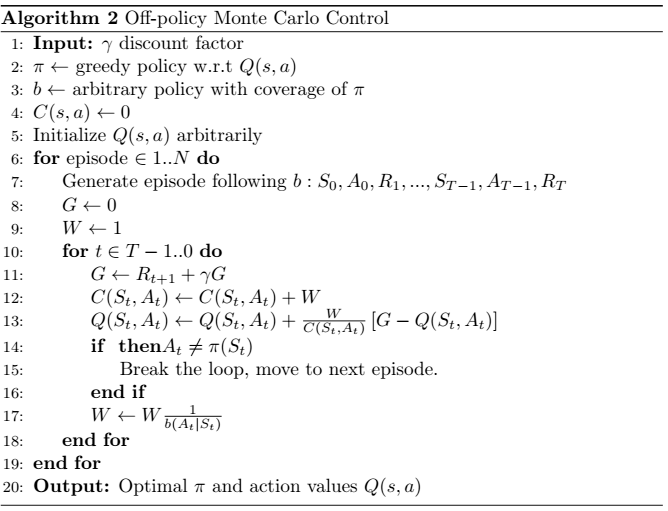

In [35]:
def off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes, gamma=0.99, epsilon=0.2):
    
    # importance sampling ratio
    csa = np.zeros((5,5,4))

    for episode in range(1,episodes+1):
        G = 0
        W = 1
        state = env.reset()
        done = False
        transitions = []
       
        while not done:
            action = exploratory_policy(state,epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state,action,reward])
            state = next_state
        
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] +=  (W/csa[state_t][action_t]) * (G -qsa)

            if action_t != target_policy(state_t):
                break
            
            W = W * 1. / (1 - epsilon + epsilon/4)

In [36]:
off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes=1000, gamma=0.99, epsilon=0.3)

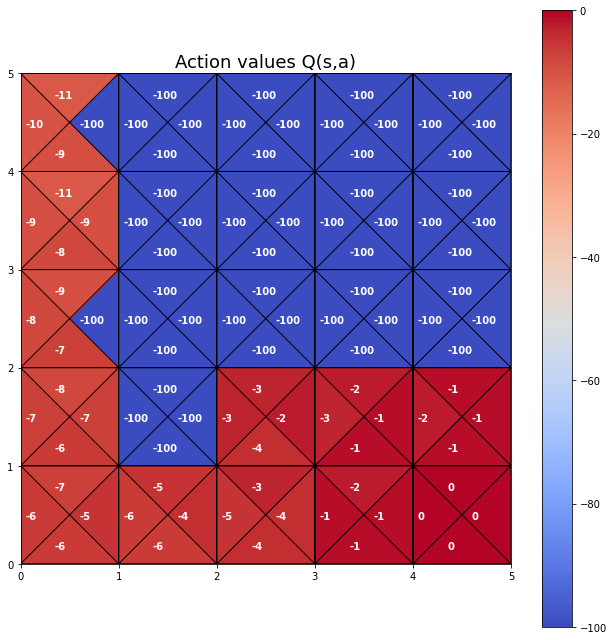

In [37]:
plot_action_values(action_values)

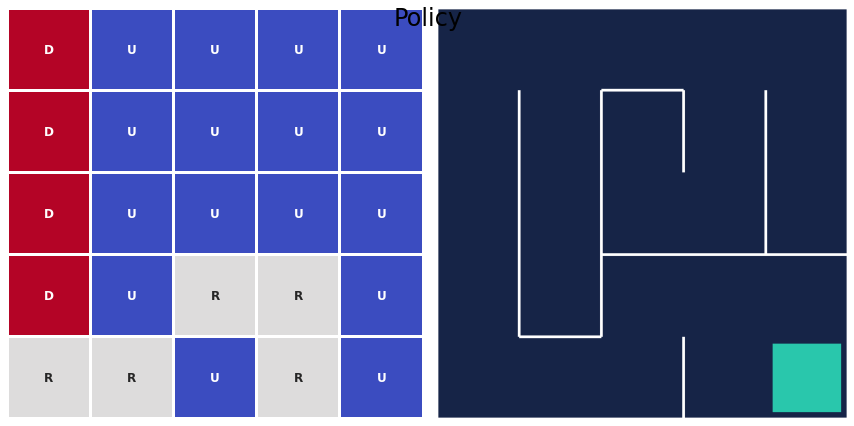

In [38]:
plot_policy(action_values,frame)

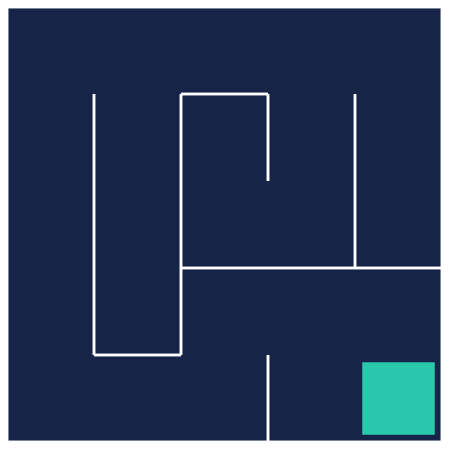

In [39]:
test_agent(env,target_policy, episodes=1)